copied and edited from:\
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

In [1]:
# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=256):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
      if (j+1) == bat_per_epo:
        print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    # evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 234/234, d=0.587, g=0.929
>2, 234/234, d=0.720, g=0.705
>3, 234/234, d=0.678, g=0.710
>4, 234/234, d=0.688, g=0.727
>5, 234/234, d=0.706, g=0.647
>6, 234/234, d=0.671, g=0.778
>7, 234/234, d=0.687, g=0.704
>8, 234/234, d=0.691, g=0.718
>9, 234/234, d=0.703, g=0.686
>10, 234/234, d=0.682, g=0.718
>Accuracy real: 64%, fake: 68%
>11, 234/234, d=0.685, g=0.711
>12, 234/234, d=0.685, g=0.702
>13, 234/234, d=0.692, g=0.702
>14, 234/234, d=0.685, g=0.732
>15, 234/234, d=0.684, g=0.708
>16, 234/234, d=0.692, g=0.724
>17, 234/234, d=0.683, g=0.724
>18, 234/234, d=0.691, g=0.650
>19, 234/234, d=0.692, g=0.708
>20, 234/234, d=0.688, g=0.711
>Accuracy real: 51%, fake: 81%
>21, 234/234, d=0.696, g=0.699
>22, 234/234, d=0.695, g=0.745
>23, 234/234, d=0.690, g=0.757
>24, 234/234, d=0.694, g=0.744
>25, 234/234, d=0.689, g=0.721
>26, 234/234, d=0.685, g=0.661
>27, 234/234, d=0.681, g=0.658
>28, 234/234, d=0.691, g=0.730
>29, 234/234, d=0.686, g=0.735
>30, 234/234, d=0.681, g=0.681
>Accuracy real: 8

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


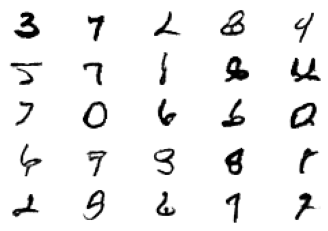

In [2]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('generator_model_1000.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


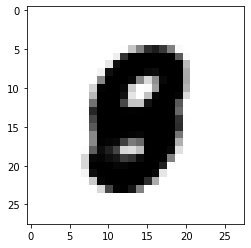

In [4]:
# example of generating an image for a specific point in the latent space
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
# load model
model = load_model('generator_model_1000.h5')
# all 0s
vector = asarray([[0.0 for _ in range(100)]])
# generate image
X = model.predict(vector)
# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()

In [24]:
from keras.models import load_model
import numpy as np

epoch = 1000
# save the discriminator model tile file
d_filename = 'discriminator_model_%03d.h5' % (epoch)
d_model.save(d_filename)

# load test data
(testX, _), (_, _) = load_data()
# expand to 3d, e.g. add channels dimension
X = expand_dims(testX, axis=-1)
# convert from unsigned ints to floats
X = X.astype('float32')
# scale from [0,255] to [0,1]
X = X / 255.0

# mnist
X_real = X

# 줄 낙서
X_anomal = X
X_anomal[:, 15, :] = 255.0

# 노이즈 X_anomal_noisy
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)


# load model
model = load_model('discriminator_model_1000.h5')

# proceed loaded model
X_pred = model.predict(X_real.reshape((60000, 28, 28, 1)))
anomal_pred = model.predict(X_anomal.reshape((60000, 28, 28, 1)))
noisy_pred = model.predict(X_noisy.reshape((60000, 28, 28, 1)))

X_pred_labels = np.argmax(X_pred, axis=1)
anomal_pred_labels = np.argmax(anomal_pred, axis=1)
noisy_pred_labels = np.argmax(noisy_pred, axis=1)

# compile before evaluation
model.compile(optimizer=model.optimizer, # 복원된 옵티마이저 사용
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# evaluate loaded model
X_loss, X_acc = model.evaluate(X_pred, X_pred_labels, verbose=2)
anomal_loss, anomal_acc = model.evaluate(anomal_pred, anomal_pred_labels, verbose=2)
noisy_loss, noisy_acc = model.evaluate(noisy_pred, noisy_pred_labels, verbose=2)

print("discriminator모델의 정확도(X): {:5.2f}%".format(100 * X_acc))
print("discriminator모델의 손실도(X): {:5.2f}%".format(100 * X_loss))

print("discriminator모델의 정확도(anomal): {:5.2f}%".format(100 * anomal_acc))
print("discriminator모델의 손실도(anomal): {:5.2f}%".format(100 * anomal_loss))

print("discriminator모델의 정확도(noisy): {:5.2f}%".format(100 * noisy_acc))
print("discriminator모델의 손실도(noisy): {:5.2f}%".format(100 * noisy_loss))



# plot the result
save_plot(X_pred, 5)
save_plot(anomal_pred, 5)
save_plot(noisy_pred, 5)

ValueError: ignored

In [0]:
####################################################################
from keras.models import load_model

# save the discriminator model tile file
d_filename = 'discriminator_model_%03d.h5' % (epoch + 1)
d_model.save(d_filename)

#####################################################################
# load model
model = load_model('discriminator_model_1000.h5')




# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)

# plot the result
save_plot(X, 5)

####################################################################
# load model
model = load_model('discriminator_model_1000.h5')



# all 0s
vector = asarray([[0.0 for _ in range(100)]])
# generate image
X = model.predict(vector)

####################################################################
# 모델 저장과 복원
# https://www.tensorflow.org/tutorials/keras/save_and_load?hl=ko

new_model = tf.keras.experimental.load_from_saved_model(saved_model_path)
new_model.summary()

# 복원된 모델 실행
model.predict(test_images).shape

# 이 모델을 평가하려면 그전에 컴파일해야 합니다.
# 단지 저장된 모델의 배포라면 이 단계가 필요하지 않습니다.

new_model.compile(optimizer=model.optimizer, # 복원된 옵티마이저를 사용합니다.
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# 복원된 모델을 평가합니다
loss, acc = new_model.evaluate(test_images,  test_labels, verbose=2)
print("복원된 모델의 정확도: {:5.2f}%".format(100*acc))